Class Distribution: 
   -- This is a regression task.# Buzz in social media Data Set

In [2]:
# https://archive.ics.uci.edu/ml/datasets/Buzz+in+social+media+#
# https://archive.ics.uci.edu/ml/machine-learning-databases/00248/regression.tar.gz

Ce script réalise les opérations suivantes:

*   Charge les données Twitter-data
*   Etiquette les colonnes du dataset
*   Donne plusieurs descriptions du dataset
*   Gère les valeurs NaN
*   Partage le dataset en deux échantillons Train (70%)/Test(30%)
*   Réduit le nombre de données à 1% du dataset total
*   Prépare le dataset (suivant la serie temporelle ou suivant les descripteurs) pour être manipulé de différentes manières
*   Observation de quelques relations entre descripteurs et jours avec Facet Grid
*   Observation pairplot par descripteurs, pour un jour fixé
*   Observation paiplot par jours, pour un descripteur fixé
*   Propose un clustering en 2 groupes (supposés Buzz et non-Buzz)
*   Observation du clustering dans un pairplot
*   Vérifie la pertinence des groupes
*   Utilise la méthode knn
*   Optimise le k-neighbors
*   Utilise la méthode CART
*   Optimise le nombre de feuilles

Dependencies :

In [1]:
# Dependencies
import numpy as np
import pandas as pd

import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import neighbors
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from matplotlib.colors import ListedColormap

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from typing import List


In [2]:
# Comment ont été choisi les variables de notre dataset ?
  # (a) être utilisable pour différents sites dédiés aux réseaux sociaux dans différentes langues, 
  # (b) passer à l’échelle pour anticiper la croissance des réseaux sociaux, 
  # (c) ne pas se reposer sur une connaissance a priori du graphe des utilisateurs 
  # du réseau social cible, car cette information est rarement disponible. 


# NB : 
  # Les descripteurs proposés dépendent du temps et nous pouvons les utiliser pour 
  # définir une série temporelle multivariée unique. Les événements tangibles sont 
  # alors associés à un motif de cette série temporelle multivariée.
  # Pour twitter chaque descripteurs est décliné sur 7 jours 
  # Les variables correspondantes dans le dataset sont nommés par :
  # "prefixe descripteur"_"num jour", ex : NAD_3

# Description des variables :
  # indice des variables : le temps (jours pour twitter -> relevés sur une semaine)
  # un individu = topic (déterminé par mot clefs ~ hashtag sur twitter)
  # NB : le libellé des topics n'aparait pas dans les variables
  #     les individus sont "anonymisés"

  # NCD : Number of Created Discussions  (columns [0,6])

  # AI(NA) : Author Increase(AI)(columns[7, 13])

  # AS(NAD) : Attention Level (measured with number of authors) (columns [14,20])

  # BL(NCD, NAD) : Burstiness Level (columns [21,27]) -> binary ?

  # NAC : Number of Atomic Containers (NAC) (columns [28,34]) # Tweet

  # AS(NAC) : Attention Level (measured with number of contributions) (columns [35,41])

  # Contribution Sparseness (CS) (columns [42,48]) -> binary

  # AT(NA, NAD) Author Interaction (columns [49,55])

  # NA : Number of Authors (columns [56,62]) 

  # ADL(NAD) : Average Discussions Length  (columns [63,69])

  # NAD : Number of active discussion (columns [70,76])

  # (Y) MNAD : Mean Number of active discussion  : Annotation(column77)
    # Construit avec les Regression Random Forests avec validation croisée répétée 
    # cinq fois sur l’ensemble des exemples pour construire notre fonction de prédiction.


# Remarques a priori :
  # 6 variables, parmis les 11, semblent être des constructions mathématiques 
  # qui intégrent au moins une autre variable du dataset.

  # MNAD semble être construite mathématiquement. Elle serait prédite par 
  # une méthode de Regression Random Forests.


# IMPORT THE DATASET

In [2]:
# Reading csv files to pandas dataframe
# Get to format of ou dataset (a Pandas dataframe and a Numpy array)
dataset_pd = pd.read_csv('Twitter-data.csv', delimiter=',', header=None)
dataset_pd.shape
# convert dataframe to numpy array
# dataset_np = dataset_pd.to_numpy()

(583250, 78)

In [3]:
# Visualize a "random" raw in the dataset
visu_index = 20000
print(dataset_pd.iloc[visu_index])

0     125.000000
1     147.000000
2     584.000000
3     370.000000
4     268.000000
5     157.000000
6      85.000000
7     107.000000
8     127.000000
9     529.000000
10    317.000000
11    227.000000
12    121.000000
13     70.000000
14      0.000136
15      0.000155
16      0.000626
17      0.000433
18      0.000319
19      0.000177
20      0.000279
21      1.000000
22      1.000000
23      1.000000
24      1.000000
25      1.000000
26      1.000000
27      1.000000
28    125.000000
29    147.000000
         ...    
48      1.000000
49      1.000000
50      1.000000
51      1.000000
52      1.000000
53      1.000000
54      1.000000
55      1.000000
56    119.000000
57    138.000000
58    556.000000
59    348.000000
60    248.000000
61    147.000000
62     81.000000
63      1.000000
64      1.000000
65      1.000000
66      1.000000
67      1.000000
68      1.000000
69      1.000000
70    125.000000
71    147.000000
72    584.000000
73    370.000000
74    268.000000
75    157.0000

# LABELIZE THE HEADER

In [4]:
# Work with the Pandas DF
col_prefixes = ['NCD_','AI_','AS(NA)_', 'BL_', 'NAC_', 'AS(NAC)_', 'CS_', 'AT_', 'NA_', 'ADL_', 'NAD_']
col_names = []

for prefixe in col_prefixes:
    for i in range(7):
        col_name = prefixe + str(i)
        col_names.append(col_name)

col_names.append("Y_target : MNAD")

dataset_pd.columns = col_names
print("Nb columns : ", len(dataset_pd.columns.values), "\n")
#print("Columns names : ")
#print(dataset_pd.columns.values)
print("\n View our DF : ")

dataset_pd.head(3)

('Nb columns : ', 78, '\n')

 View our DF : 


,NCD_0,NCD_1,NCD_2,NCD_3,NCD_4,NCD_5,NCD_6,AI_0,AI_1,AI_2,...,ADL_5,ADL_6,NAD_0,NAD_1,NAD_2,NAD_3,NAD_4,NAD_5,NAD_6,Y_target : MNAD
0,0,2,0,0,1,1,1,0,1,0,...,1.0,1.0,0,2,0,0,1,1,1,0.0
1,2,1,0,0,0,0,4,2,1,0,...,0.0,1.0,2,1,0,0,0,0,4,0.5
2,1,0,0,0,0,4,1,1,0,0,...,1.0,1.0,1,0,0,0,0,4,1,0.0


# DESCRIBE THE DATASET WITH THE MAIN FEATURES

In [5]:
print(dataset_pd.describe())

               NCD_0          NCD_1          NCD_2          NCD_3  \
count  583250.000000  583250.000000  583250.000000  583250.000000   
mean      140.339640     136.770147     159.679271     181.592091   
std       431.772639     432.305129     502.057428     574.883713   
min         0.000000       0.000000       0.000000       0.000000   
25%         3.000000       3.000000       4.000000       4.000000   
50%        18.000000      17.000000      21.000000      24.000000   
75%       104.000000     100.000000     115.000000     131.000000   
max     24210.000000   29574.000000   37505.000000   72366.000000   

               NCD_4          NCD_5          NCD_6           AI_0  \
count  583250.000000  583250.000000  583250.000000  583250.000000   
mean      201.097445     220.175371     219.388214      71.038051   
std       630.448432     669.205930     672.182204     196.876718   
min         0.000000       0.000000       0.000000       0.000000   
25%         5.000000       6.0000

## Analyze missing values in the datasets

In [6]:
#print(dataset_pd.isna().head())
#print(dataset_pd.isna().sum())
print('\nMissing Data (NaN) : ', dataset_pd.isna().sum().sum(), ' & Shape is : ', dataset_pd.shape)
# To "normalize NaN types, if it needs -> df.loc[df['y'] == 'N/A','y'] = np.nan
# Fill missing values with mean column values in the train set
# dataset_pd.fillna(dataset_pd.mean(), inplace=True)
# Still missing values for categorical variables

('\nMissing Data (NaN) : ', 0, ' & Shape is : ', (583250, 78))


### There is not any missing values.  

# Separate X data (11 features) and Y target (MNAD)

In [7]:
X_data = dataset_pd.iloc[:, :-1]
Y_target = dataset_pd.iloc[:, -1:]
print('X : ', X_data.shape)
print('Y : ', Y_target.shape)

('X : ', (583250, 77))
('Y : ', (583250, 1))


# Firstly, redduce our dataset
(to 1% of 580k entities)


In [8]:
# to accelerate our first computing
# we split our dataset to minify the dataset to 1% sizing
X_use, X_reserve, Y_use, Y_reserve = train_test_split(
    X_data, 
    Y_target, 
    test_size=0.99, 
    random_state=random.seed())

print('TO USE : ')
print('\tX : ', X_use.shape)
print('\tY : ', Y_use.shape)

print('RESERVED : ')
print('\tX : ', X_reserve.shape)
print('\tY : ', Y_reserve.shape)


TO USE : 
('\tX : ', (5832, 77))
('\tY : ', (5832, 1))
RESERVED : 
('\tX : ', (577418, 77))
('\tY : ', (577418, 1))


# Then get the training and the testing sets
we split the dataset to get the training set and the testing set (70-30%) :

In [9]:
# we split our dataset to get a 30% sized training set 
X_train, X_test, Y_train, Y_test = train_test_split(
    X_use, 
    Y_use, 
    test_size=0.3, 
    random_state=random.seed())

print(X_train.shape)
print(X_test.shape)

(4082, 77)
(1750, 77)


## An other method to split our dataset

In [10]:
# Shuffle and redduce dataset
data_use = dataset_pd.sample(frac=0.01, axis=0)
data_reserve = dataset_pd.drop(data_use.index)

# Shuffle and split train and test data
data_train = data_use.sample(frac=0.7, axis=0)
data_test = data_use.drop(data_train.index)

# Split date and target (X, Y)
X_train = data_train.drop('Y_target : MNAD', axis=1)
Y_train = data_train['Y_target : MNAD']
X_test = data_test.drop('Y_target : MNAD', axis=1)
Y_test = data_test['Y_target : MNAD']

# Standardize our data
In anticipation of a neural network :
* All data must be normalized, train and test
* We have to substract the mean and divide by the standar deviation
* Attention : test data should not be used in anyway, even for normalization
* The mean and the standard deviation will therefore only be calculated with the train data

In [15]:
mean = X_train.mean()
std = X_train.std()
X_train_std = (X_train - mean) / std
X_test_std = (X_test - mean) / std
print(X_train_std.describe())

              NCD_0        NCD_1         NCD_2         NCD_3         NCD_4  \
count  4.083000e+03  4083.000000  4.083000e+03  4.083000e+03  4.083000e+03   
mean   3.132444e-17     0.000000  2.001284e-17  1.870765e-17  1.740247e-18   
std    1.000000e+00     1.000000  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.043136e-01    -0.298935 -3.013829e-01 -2.907846e-01 -2.998690e-01   
25%   -2.976207e-01    -0.292331 -2.938050e-01 -2.844507e-01 -2.924538e-01   
50%   -2.663870e-01    -0.263717 -2.634933e-01 -2.559485e-01 -2.613100e-01   
75%   -7.898514e-02    -0.089827 -9.488486e-02 -9.285262e-02 -9.669230e-02   
max    3.123721e+01    30.358506  2.757774e+01  3.414779e+01  2.783492e+01   

              NCD_5         NCD_6          AI_0          AI_1          AI_2  \
count  4.083000e+03  4.083000e+03  4.083000e+03  4.083000e+03  4.083000e+03   
mean  -6.090864e-18 -6.960987e-18 -1.392197e-17 -2.175308e-18 -3.393481e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+0

# Separate each period of the serie

In [16]:
# Separate each period
def separate_periods_pd(df_pd, num_periods=7):
    list_df_period = []
    for i in range(num_periods):
        list_df_period.append(df_pd.filter(like=str(i), axis=1))
    return list_df_period

In [17]:
list_df_periods = separate_periods_pd(X_train)

print('The first period = the first day in the week : \n')
print(list_df_periods[0].head(3))
print('\nDescription :\n')
print(list_df_periods[0].describe())

# Concatenate the training data set with the training target set
df_period_0_with_target = pd.concat([list_df_periods[0], Y_train], axis=1)

The first period = the first day in the week : 

        NCD_0  AI_0  AS(NA)_0  BL_0  NAC_0  AS(NAC)_0  CS_0  AT_0  NA_0  \
431232      1     1  0.000001   1.0      1   0.000001   1.0   1.0     1   
159431    394   324  0.001167   1.0    394   0.000580   1.0   1.0   369   
395782     17    15  0.000058   1.0     17   0.000026   1.0   1.0    17   

        ADL_0  NAD_0  
431232    1.0      1  
159431    1.0    394  
395782    1.0     17  

Description :

              NCD_0         AI_0     AS(NA)_0         BL_0         NAC_0  \
count   4083.000000  4083.000000  4083.000000  4083.000000   4083.000000   
mean     136.403870    67.059515     0.000191     0.930276    146.471957   
std      448.234547   175.060152     0.000518     0.246902    463.843337   
min        0.000000     0.000000     0.000000     0.000000      0.000000   
25%        3.000000     2.000000     0.000004     1.000000      3.000000   
50%       17.000000    11.000000     0.000024     1.000000     19.000000   
75%      1

## Facet grid view

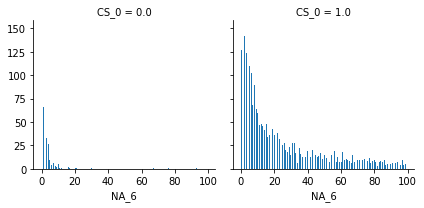

In [18]:
# Some Graphics with BL and CS wich are binaries
df_temp = X_train[X_train["NA_6"] < 100]
g = sns.FacetGrid(df_temp , col='CS_0')
g.map(plt.hist, 'NA_6', bins=200)

Une interprétation possible de ces deux graphs : 
* les sujets à faibles contribution (CS) dès le premiers jours n'ont que très peu de nouveaux auteurs (NA) au 7ème jour ;
* autrement dit, il n'y a pas de sujet faibles (CS) au premier jour avec plus de 20 nouveaux auteurs au dernier jour (le sujet se meurt).
* il y a bien plus de sujet avec peu d'auteurs.



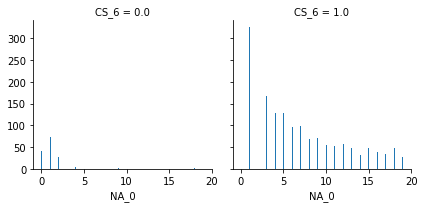

In [19]:
# Some Graphics with BL and CS wich are binaries
df_temp = X_train[X_train["NA_0"] < 20]
g = sns.FacetGrid(df_temp , col='CS_6')
g.map(plt.hist, 'NA_0', bins=200)

Ici, on comprend que : 
* les sujets qui n'ont pas assez d'auteurs le premier jour, ne seront pas engageant le dernier jour.

# Pair plot of a period

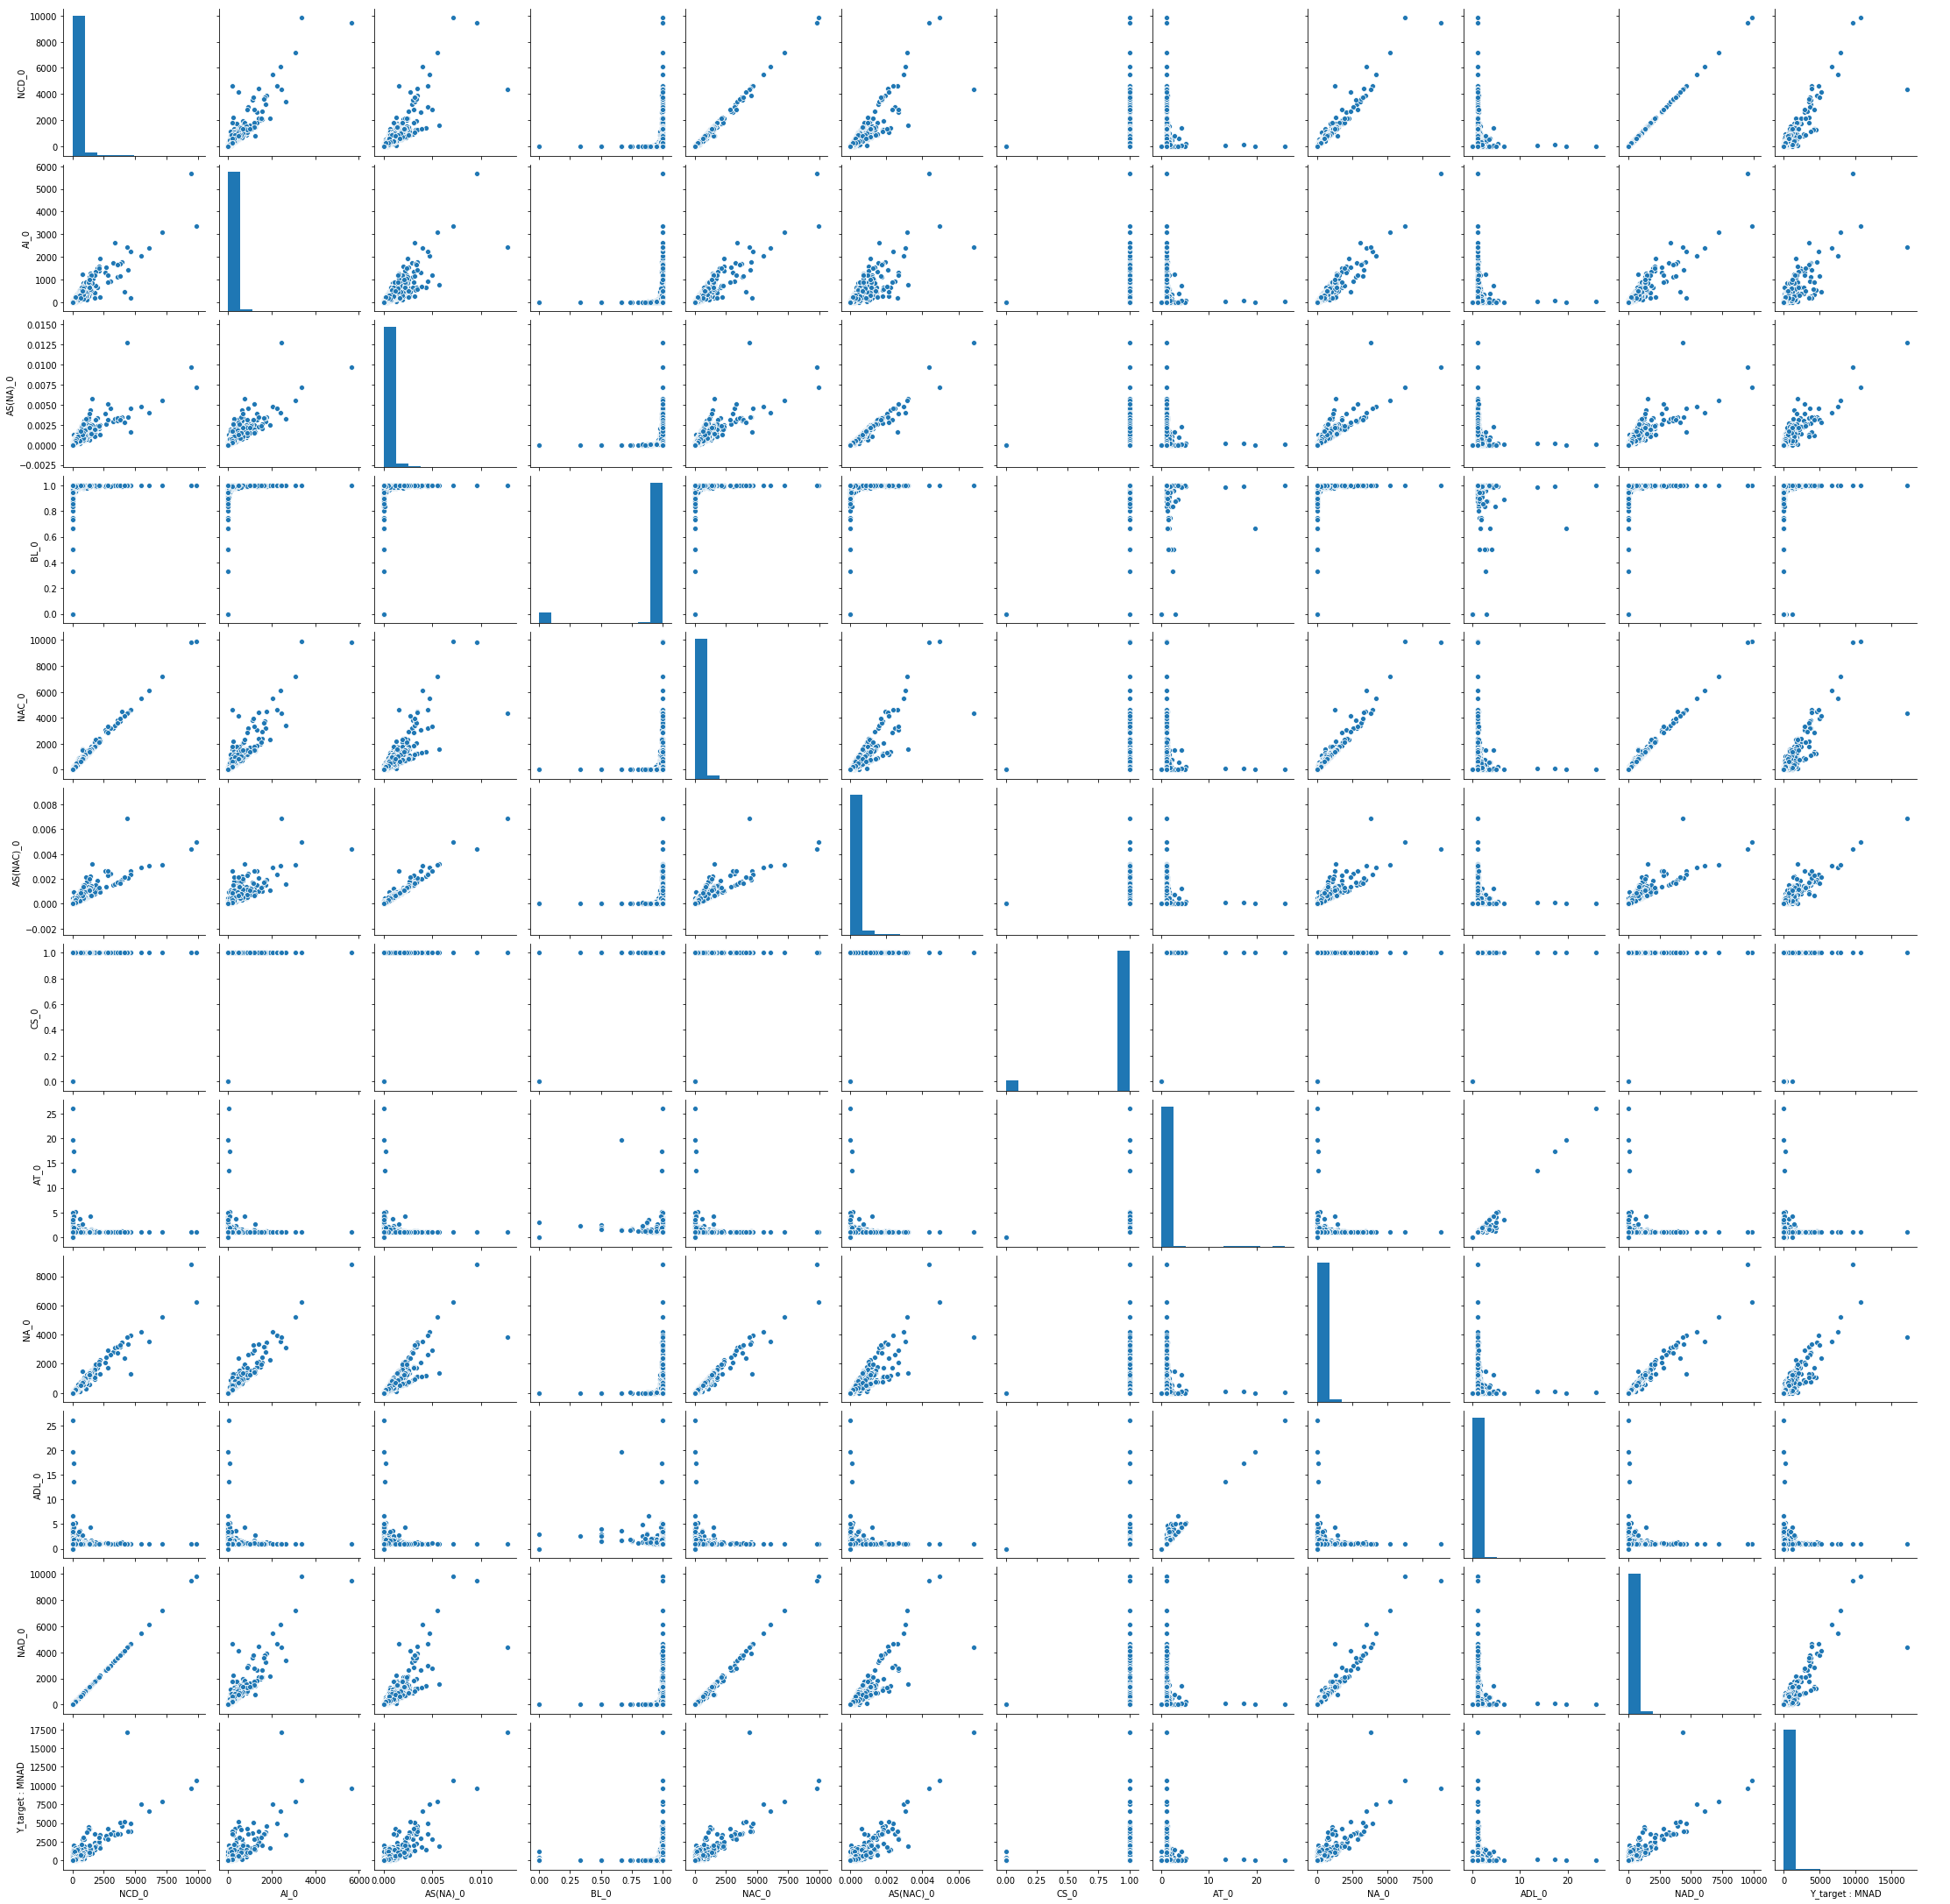

In [17]:
#sns.pairplot(pd.DataFrame(list_df_periods[0])) 
sns.pairplot(pd.DataFrame(df_period_0_with_target))

On observe NCD = NAD, NCD = NAC et NAC = NAD, semblent linéairement liés.
Pour mémoire: 
* NCD : Number of Created Discussions
* NAD : Number of active discussion
* NAC : Number of Atomic Containers ~ Tweet
Ces relations sembles a priorr normales surtout le premier jour d'observation (initialisation d'une thématique)
CS montre un comprtement binaire.
Par ailleurs, BL possède une signature assez particulière qu'on retrouve avec chaque feature : une sorte de passe-haut.
De plus, dans certaines paires on observe comme des groupes qui se forment (3 droites) : AS(NA)/NCD, AS(NA)/NAC, AS(NA)/NAD. On retrouve les features proportionnelles entre elles...

### Verify the observation on the last day (6)

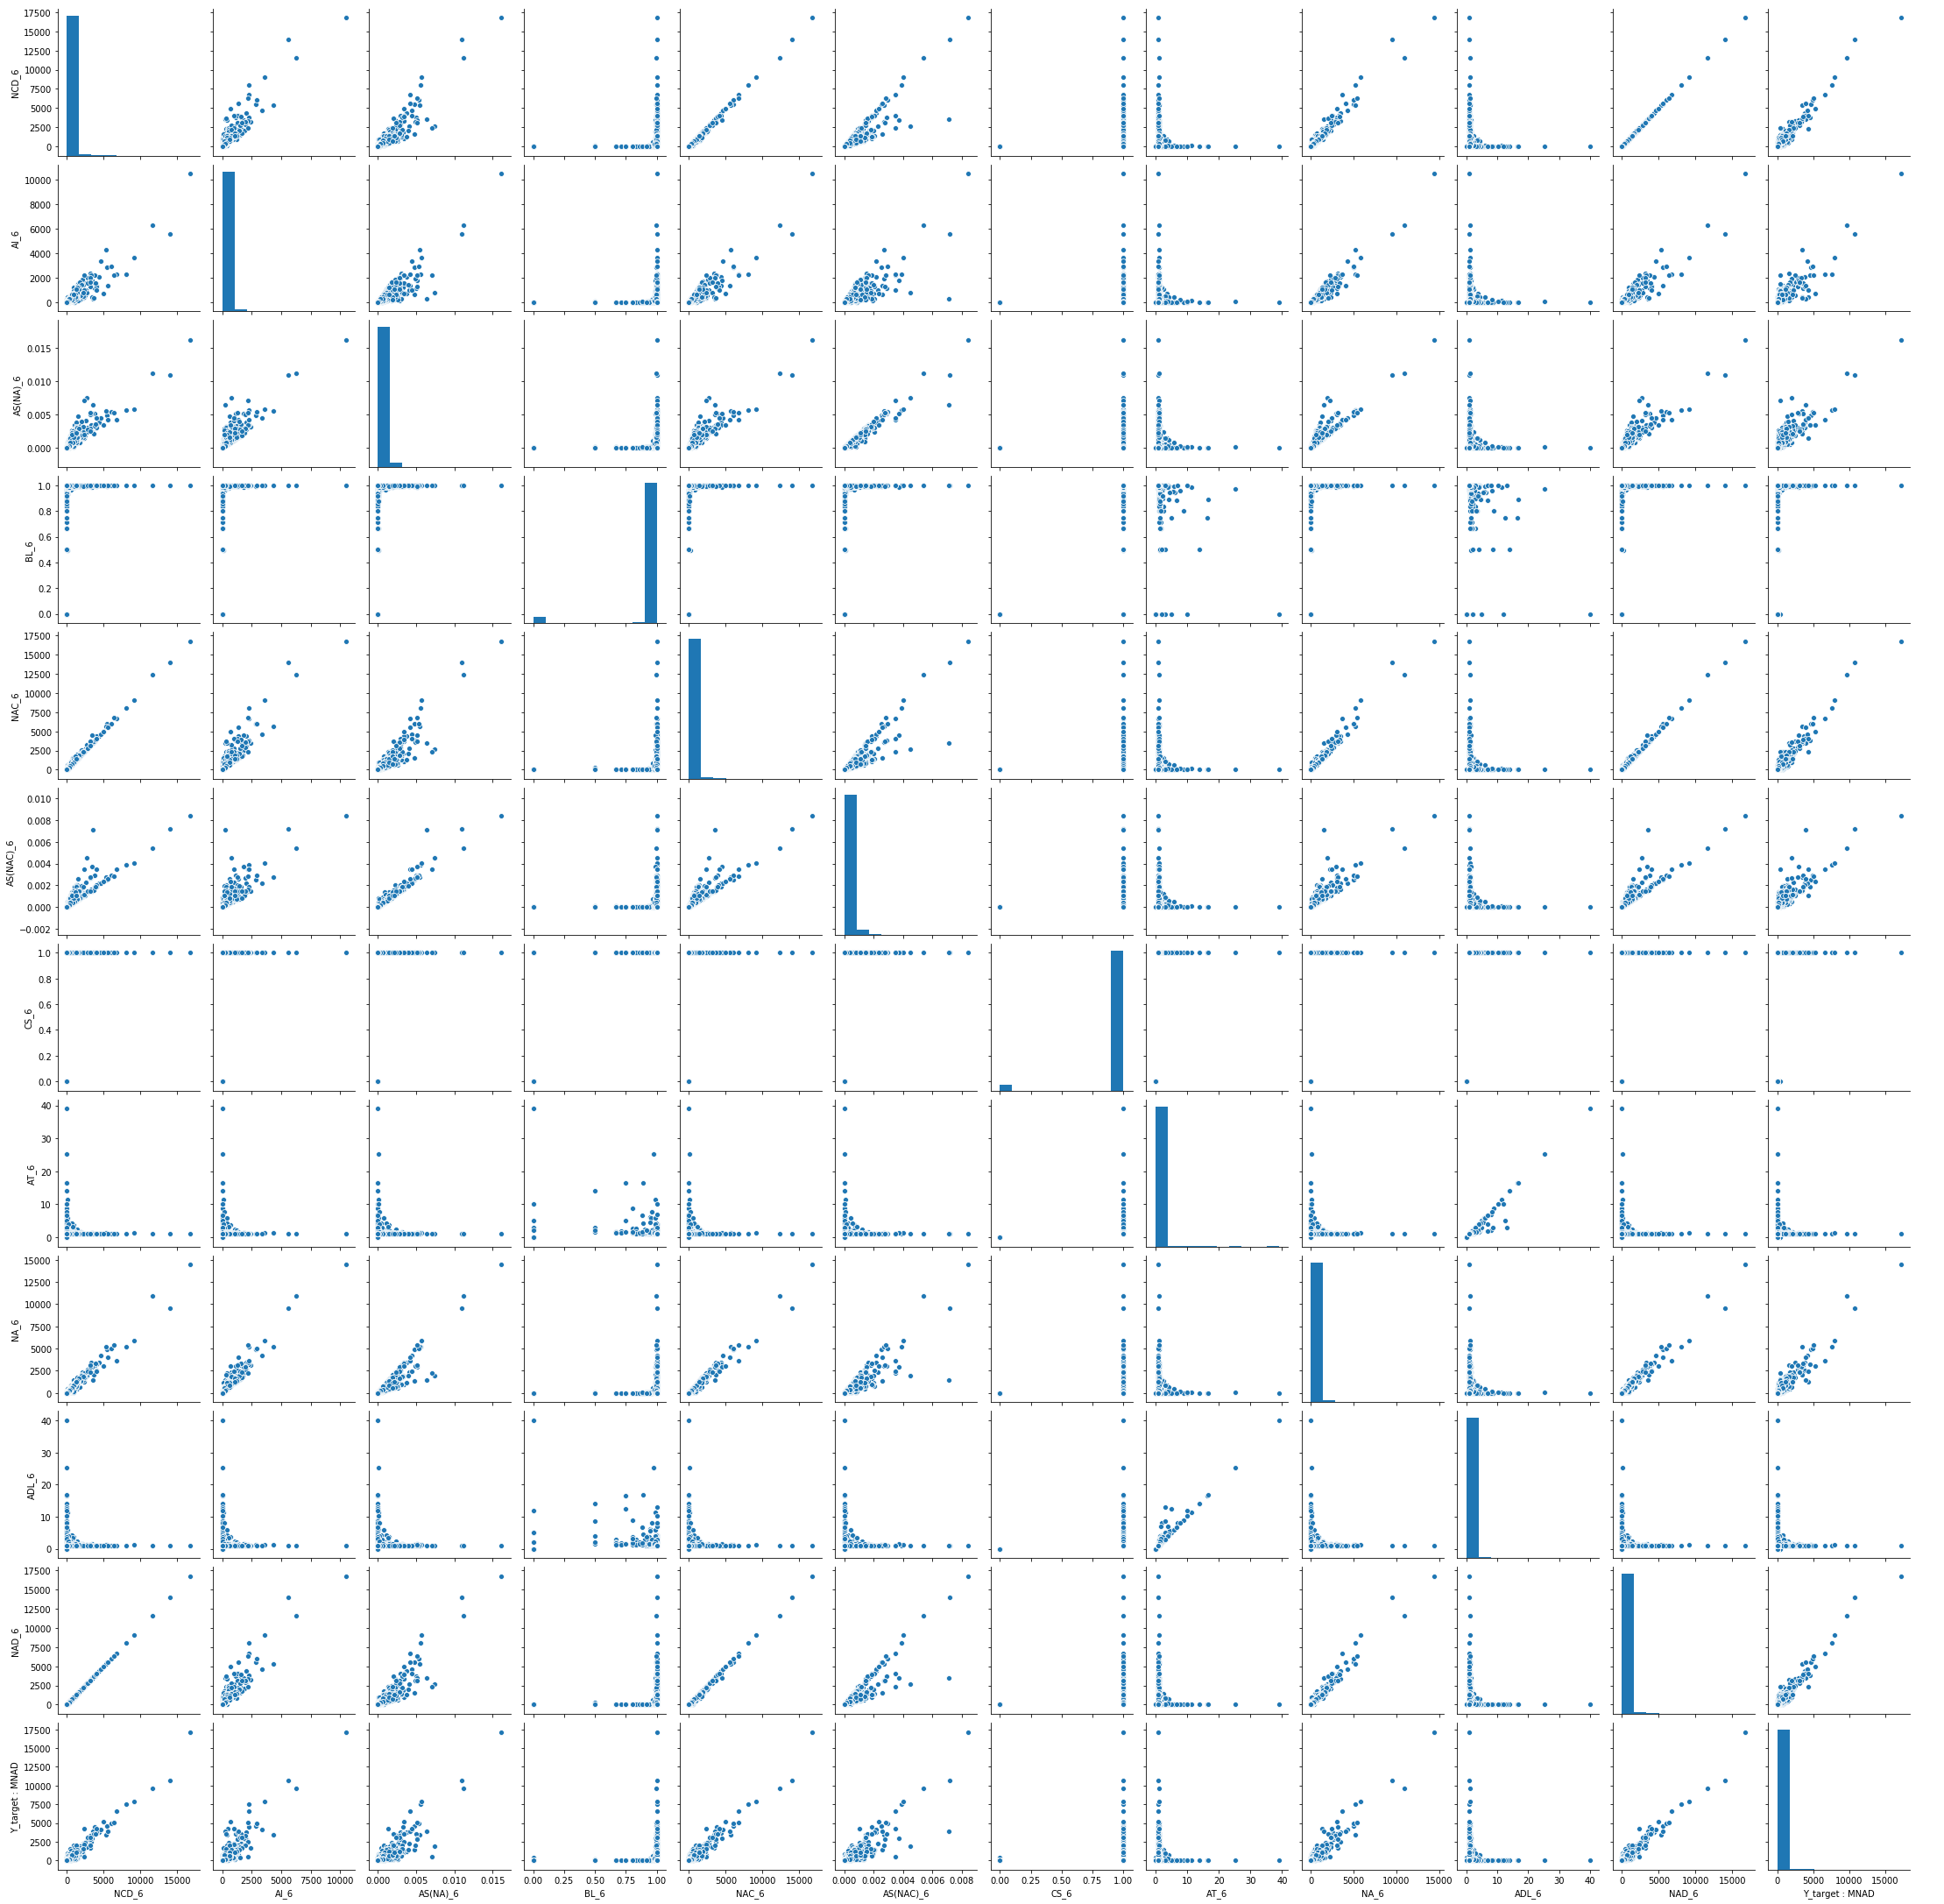

In [18]:
# Concatenate the training data set with the training target set
df_period_6_with_target = pd.concat([list_df_periods[6], Y_train], axis=1)
sns.pairplot(pd.DataFrame(df_period_6_with_target))

Finalement, tout pousse à croire que nos premiers constats ne dépendent pas du jour de l'observation.

In [20]:
# Separate each descriptor
def separate_descriptors_pd(df_pd, num_periods=7):
    list_df_descriptor = []
    for i, _ in enumerate(col_prefixes):
        i_start = i * num_periods 
        i_end = num_periods * (i + 1)
        list_df_descriptor.append(df_pd.iloc[:,i_start:i_end])
    return list_df_descriptor

In [21]:
list_df_descriptors = separate_descriptors_pd(X_train)

print('The first period = the first day in the week : \n')
print(list_df_descriptors[1])
print('\nDescription :\n')
print(list_df_descriptors[1].describe())

The first period = the first day in the week : 

        AI_0  AI_1  AI_2  AI_3  AI_4  AI_5  AI_6
431232     1     2     1     8     4     5     1
159431   324  1897  1590  1682  1837  1713  1679
395782    15    10    21    18     8    20    17
411220    17    27    43    24    30    40    28
498033     2     3     4     0     3     0    15
96156     13     8     6     3     9    10    14
105023     2     3     5     0     4     7     1
211086     2     0     1     0     0     1     3
346215     2     0     0     1     1     2     0
352147   226   295   316   283   285   337   417
14803      3     7     3     2     1     2    11
235118     4     1     2     1     1     3     2
205872    82    64   106   100   233   224   169
532498    28    29    20    34    20    39    27
364173    13    15    12    12    10    19    21
321432   215   236   266   213   245   584   389
320135    14    20    11    18    17    24    16
245679    50    29    51    31    36    59    50
2003      53    57  

# Pair plot of each descriptor
### !!!! Attention : chronophage !!! 

In [ ]:
# !!!! Attention : chronophage - 
# -> risque de mort instantannée d'une machine sous-dimensionnée !!! 
for i, column in enumerate(col_prefixes):
    # Concatenate the training data set with the training target set
    descriptor_with_target = pd.concat([list_df_descriptors[i], Y_train], axis=1)
    print("Paiplot for : ", column)
    sns.pairplot(pd.DataFrame(descriptor_with_target))

In [ ]:
### Or test each of them manually

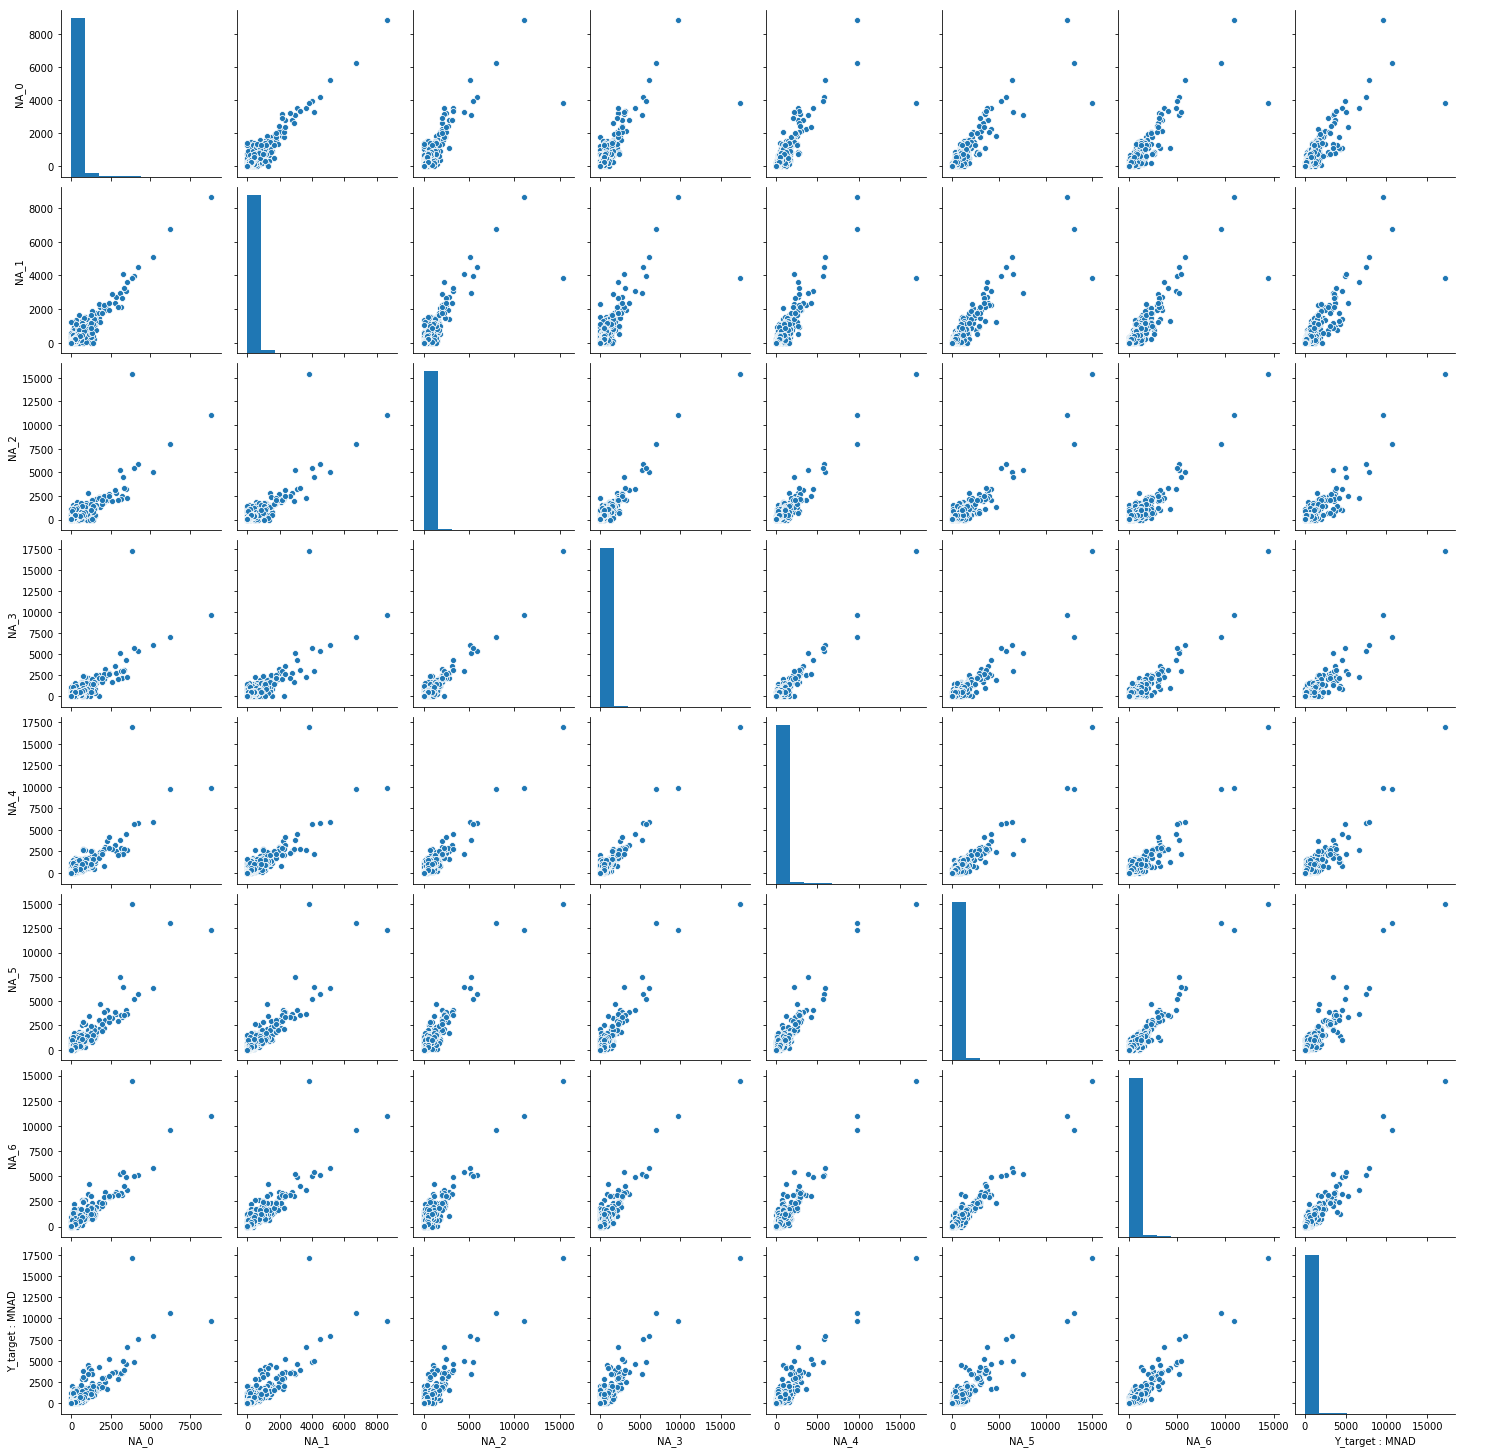

In [21]:
# Concatenate the training data set with the training target set
descriptor_with_target = pd.concat([list_df_descriptors[8], Y_train], axis=1)
sns.pairplot(pd.DataFrame(descriptor_with_target))

Globalement on remarque que chaque feature conserve la même allure peu importe le jour. Néanmoins, la plupart des features ont une allure "précisée" plus elles sont proches de la diagonale du pairplot. On peut interpréter cela en affirmant qu'il existe une relation lineaire un peu plus franche d'un jour sur l'autre des observations. Comme si les phénomènes d'un jour amenait assez logiquement ceux du lendemain. 
De plus, la plupart des pairplot ont des allures croissantes. On peut en déduire que plus un phénomène de Buzz commence fort, plus il terminera fort.

### Nota bene

cf. https://www.researchgate.net/publication/282172597 "Dans le cas de Twitter les descripteurs suivants : NAC , NCD , ainsi que NAD sont importants pour prédire qu’un mot-clé va connaître une période de fort intérêt."

On pourrait donc réduire notre dataset aux colonnes NAC, NCD et NAD.
Nous souhaitons vérifier cela.
Mais pour ça nous devons comprendre quel est le seuil de MNAD à partir duquel on peut parler de buzz car cela n'est pas explicite dans l'article

# ROUND 0 : try to cluster buzz or not buzz
In order to understand how it's labelled

In [22]:
# concatenate the X and Y dataset to have all data in one df
# Describe it here to be compare further
X_Y_train = pd.concat([X_train, Y_train], axis=1)
X_Y_train.iloc[:,-8:].describe()

,NAD_0,NAD_1,NAD_2,NAD_3,NAD_4,NAD_5,NAD_6,Y_target : MNAD
count,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000,4083.000000
mean,136.845457,136.197404,159.490326,184.099927,202.680382,220.548126,218.156503,188.362111
std,448.841407,454.762808,528.321666,632.229161,674.939391,728.284411,711.245281,649.787985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,4.000000,4.000000,5.000000,6.000000,6.000000,4.500000
50%,17.000000,16.000000,20.000000,23.000000,26.000000,30.000000,28.000000,24.000000
75%,101.000000,96.000000,109.500000,126.000000,137.000000,160.000000,155.000000,125.750000
max,14138.000000,13929.000000,14727.000000,21749.000000,18971.000000,24764.000000,24976.000000,23042.500000


In [23]:
km = KMeans(n_clusters=2, random_state=0,)

In [24]:
# Fit the dataset without the target Y
km.fit(X_train)

print("'Non-supervised' clustering result :")
print("Verify the shape of the result", km.labels_.shape)
print("The result seems like that : ", km.labels_)
print("How many 1 in the result ? : ", km.labels_.sum())

'Non-supervised' clustering result :
('Verify the shape of the result', (4083,))
('The result seems like that : ', array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
('How many 1 in the result ? : ', 28)


In [25]:
# On ajoute ces nouveaux labels à nos différentés vues du dataset que nous utiliserons plus loin (pairplot) 
cluster_without_Y_0 = X_train[km.labels_ == 0]
cluster_without_Y_1 = X_train[km.labels_ == 1]
# On labelise notre dataset
X_train_label = X_train.copy()
X_train_label["label"] = km.labels_

for i in range(len(list_df_descriptors)):
    list_df_descriptors[i]["label"] = X_train_label["label"]

for i in range(len(list_df_periods)):
    list_df_periods[i]["label"] = X_train_label["label"]
    
# On affiche une description des dernières colonnes qui paraissent les plus pertinentes pour évaluer le résultat
# On peut comparer aux descriptions du dataset original
print("GROUP N°X-0 :")
print(cluster_without_Y_0.iloc[:,-7:].describe())
print("GROUP N°X-1 :")
print(cluster_without_Y_1.iloc[:,-7:].describe())


/home/comozone/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


GROUP N°X-0 :
             NAD_0        NAD_1        NAD_2        NAD_3        NAD_4  \
count  4055.000000  4055.000000  4055.000000  4055.000000  4055.000000   
mean    110.615783   109.874476   129.217756   148.327497   162.623181   
std     237.669483   244.584332   288.462427   319.724840   346.373095   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       3.000000     3.000000     4.000000     4.000000     5.000000   
50%      16.000000    15.000000    20.000000    22.000000    25.000000   
75%      97.000000    92.500000   106.500000   120.000000   133.000000   
max    2218.000000  2354.000000  2653.000000  2807.000000  4564.000000   

             NAD_5        NAD_6  
count  4055.000000  4055.000000  
mean    178.840691   178.494205  
std     375.656902   369.204039  
min       0.000000     0.000000  
25%       6.000000     6.000000  
50%      29.000000    27.000000  
75%     155.000000   149.500000  
max    4945.000000  3649.000000  
GROUP N°X-1 :

In [26]:
# Try it including the Y target to 'check' our previous result...
# Fit the dataset with the target Y
km.fit(X_Y_train)
print("'Supervised' clustering result :")
print("Verify the shape of the result ", km.labels_.shape)
print("The result seems like that : ", km.labels_)
print("How many 1 in the result ? : ", km.labels_.sum())

'Supervised' clustering result :
('Verify the shape of the result ', (4083,))
('The result seems like that : ', array([0, 0, 0, ..., 0, 0, 0], dtype=int32))
('How many 1 in the result ? : ', 29)


In [27]:
cluster_with_Y_0 = X_Y_train[km.labels_ == 0]
cluster_with_Y_1 = X_Y_train[km.labels_ == 1]
X_Y_train["label"] = km.labels_
# On affiche une description des dernières colonnes qui paraissent les plus pertinentes pour évaluer le résultat
# On peut comparer aux descriptions du dataset original
print("GROUP N°XY-0 :")
print(cluster_with_Y_0.iloc[:,-8:].describe())
print("GROUP N°XY-1 :")
print(cluster_with_Y_1.iloc[:,-8:].describe())

GROUP N°XY-0 :
             NAD_0        NAD_1        NAD_2        NAD_3        NAD_4  \
count  4054.000000  4054.000000  4054.000000  4054.000000  4054.000000   
mean    110.095955   109.424766   128.772077   147.726196   161.897385   
std     235.382033   242.932033   287.098346   317.462908   343.318079   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       3.000000     3.000000     4.000000     4.000000     5.000000   
50%      16.000000    15.000000    20.000000    22.000000    25.000000   
75%      97.000000    92.000000   106.000000   120.000000   133.000000   
max    2133.000000  2354.000000  2653.000000  2807.000000  4564.000000   

             NAD_5        NAD_6  Y_target : MNAD  
count  4054.000000  4054.000000      4054.000000  
mean    178.016034   177.696349       152.988777  
std     372.014256   365.736672       332.728433  
min       0.000000     0.000000         0.000000  
25%       6.000000     6.000000         4.500000  
50%      29.

# But, 
* yet, without the real labelization of the target, we can't verify anything ...
* because it's not explicit enough in the scientific paper
* for example, we could expect that the max of NAD or MNAD is the buzz, but it's not obvious as such
* Nevertheless it is interesting to note that in both cases, supervised or not, the clustering determines a group of the same number of individuals
* The clustering looks similar in the two cases

### Check the clustering
Check if integrate Y or not is relevant in the clusering.
For this, we'll the confusion matrix

In [28]:
# Compute the confusion matrix between labels found thanks to 'supervised clustering' or not
cm = confusion_matrix(X_Y_train["label"], X_train_label["label"])
print(cm)

[[4054    0]
 [   1   28]]


In [378]:
# Compute the adjusted rand Index between the clusters and the true labels 
ari = adjusted_rand_score(X_Y_train["label"], X_train_label["label"])
print(ari)

1.0


We note that there is a huge similarity between the to clustering, with or without Y.
So we consider these label are relevant.

In [29]:
#  Mean value for each label
X_Y_train[['label', 'Y_target : MNAD']].groupby(['label'], as_index=False).mean().sort_values(by='label', ascending=False)

,label,Y_target : MNAD
1,1,5133.310345
0,0,152.988777


In [30]:
# Are the two groups (Buzz - 1 label or not - 0 label) disjoined ?
X_Y_train["label"]
cluster_0_min = cluster_with_Y_0["Y_target : MNAD"].min()
cluster_0_max = cluster_with_Y_0["Y_target : MNAD"].max()
cluster_1_min = cluster_with_Y_1["Y_target : MNAD"].min()
cluster_1_max = cluster_with_Y_1["Y_target : MNAD"].max()

print("group_0_min : ", cluster_0_min)
print("group_0_max : ", cluster_0_max)
print("group_1_min : ", cluster_1_min)
print("group_1_max : ", cluster_1_max)

('group_0_min : ', 0.0)
('group_0_max : ', 4742.0)
('group_1_min : ', 1409.5)
('group_1_max : ', 23042.5)


In [31]:
# How many values of Y_target are shared between the two clusters ?
# Between group_1_min and group_0_max ?
df = X_Y_train[(cluster_1_min < X_Y_train["Y_target : MNAD"]) & (X_Y_train["Y_target : MNAD"] < cluster_0_max)]
print("There are :", df.shape[0], "/",  X_Y_train.shape[0], " values in the '0/1 shared zone'")

('There are :', 86, '/', 4083, " values in the '0/1 shared zone'")


#### We could consider that all entities with a Y_MNAD > group_1_min ~ 4000, are buzz
Almost 20 entities above 4000

## View the clustering result with Pairplot

### Firstly, preview, with the X_train dataset (without Y_target)

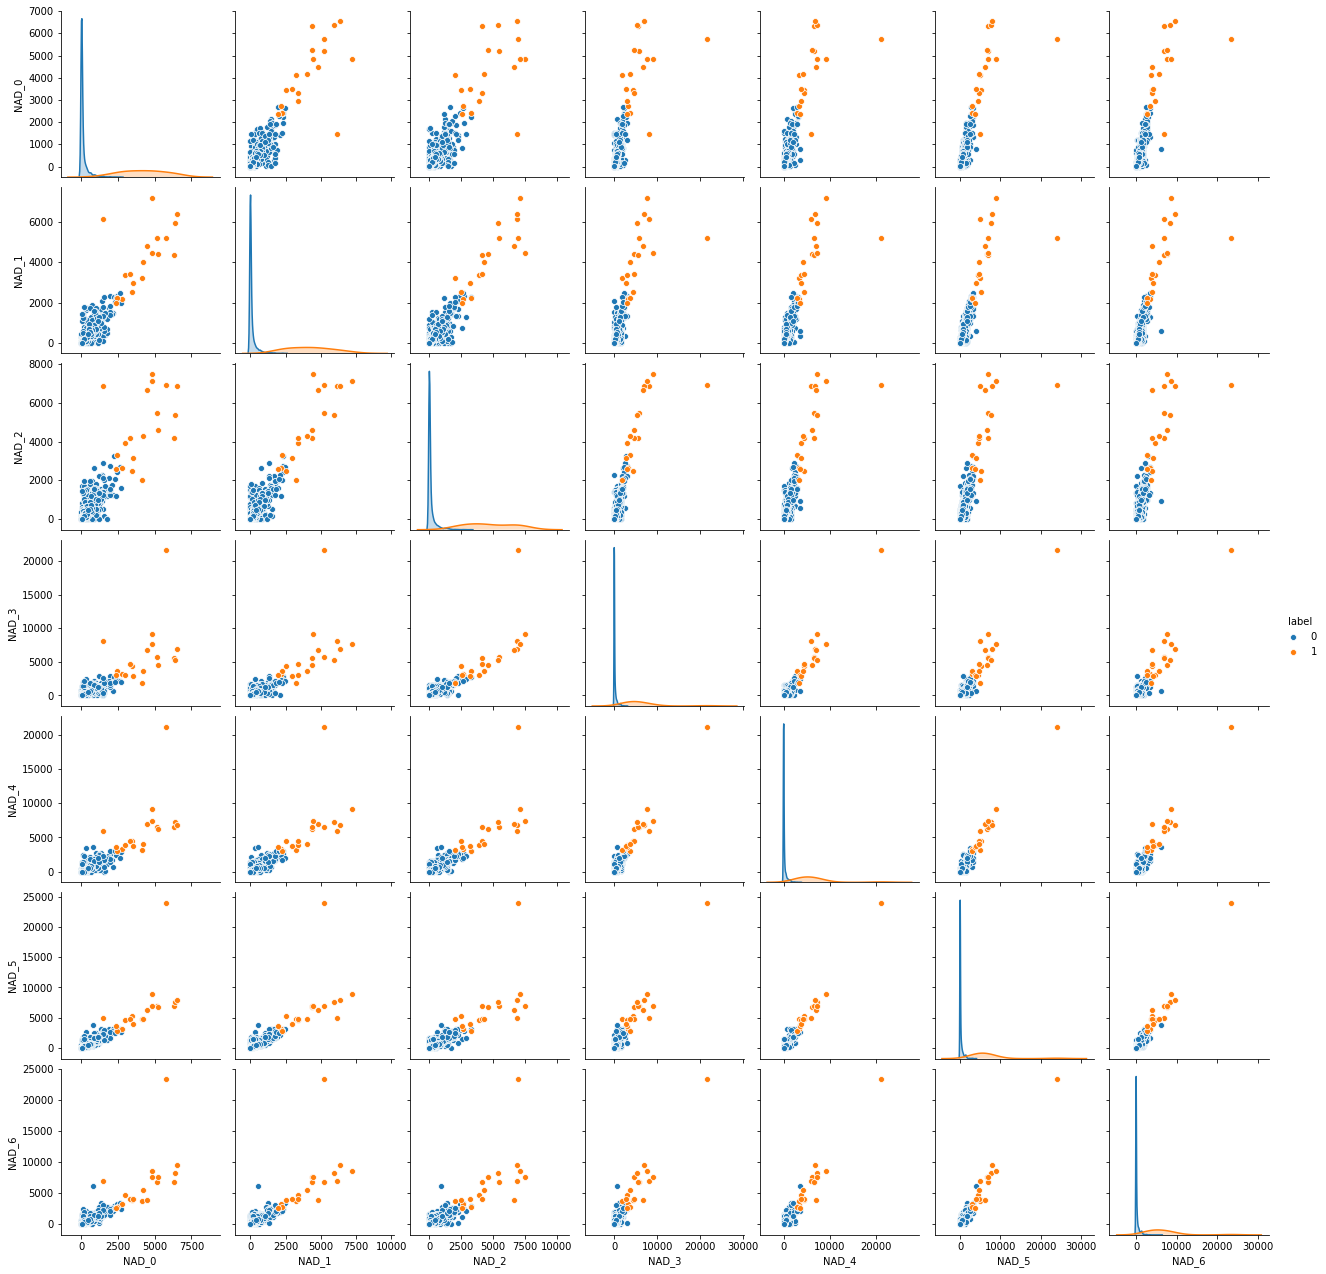

In [39]:
sns.pairplot(X_train_label.iloc[:,-8:], hue='label', height=2.5);

In [ ]:
### Secondly, we want pairplot on descriptor for each period, in order to determine wich is important on the clustering ')

/usr/local/lib/python2.7/dist-packages/seaborn/distributions.py:290: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


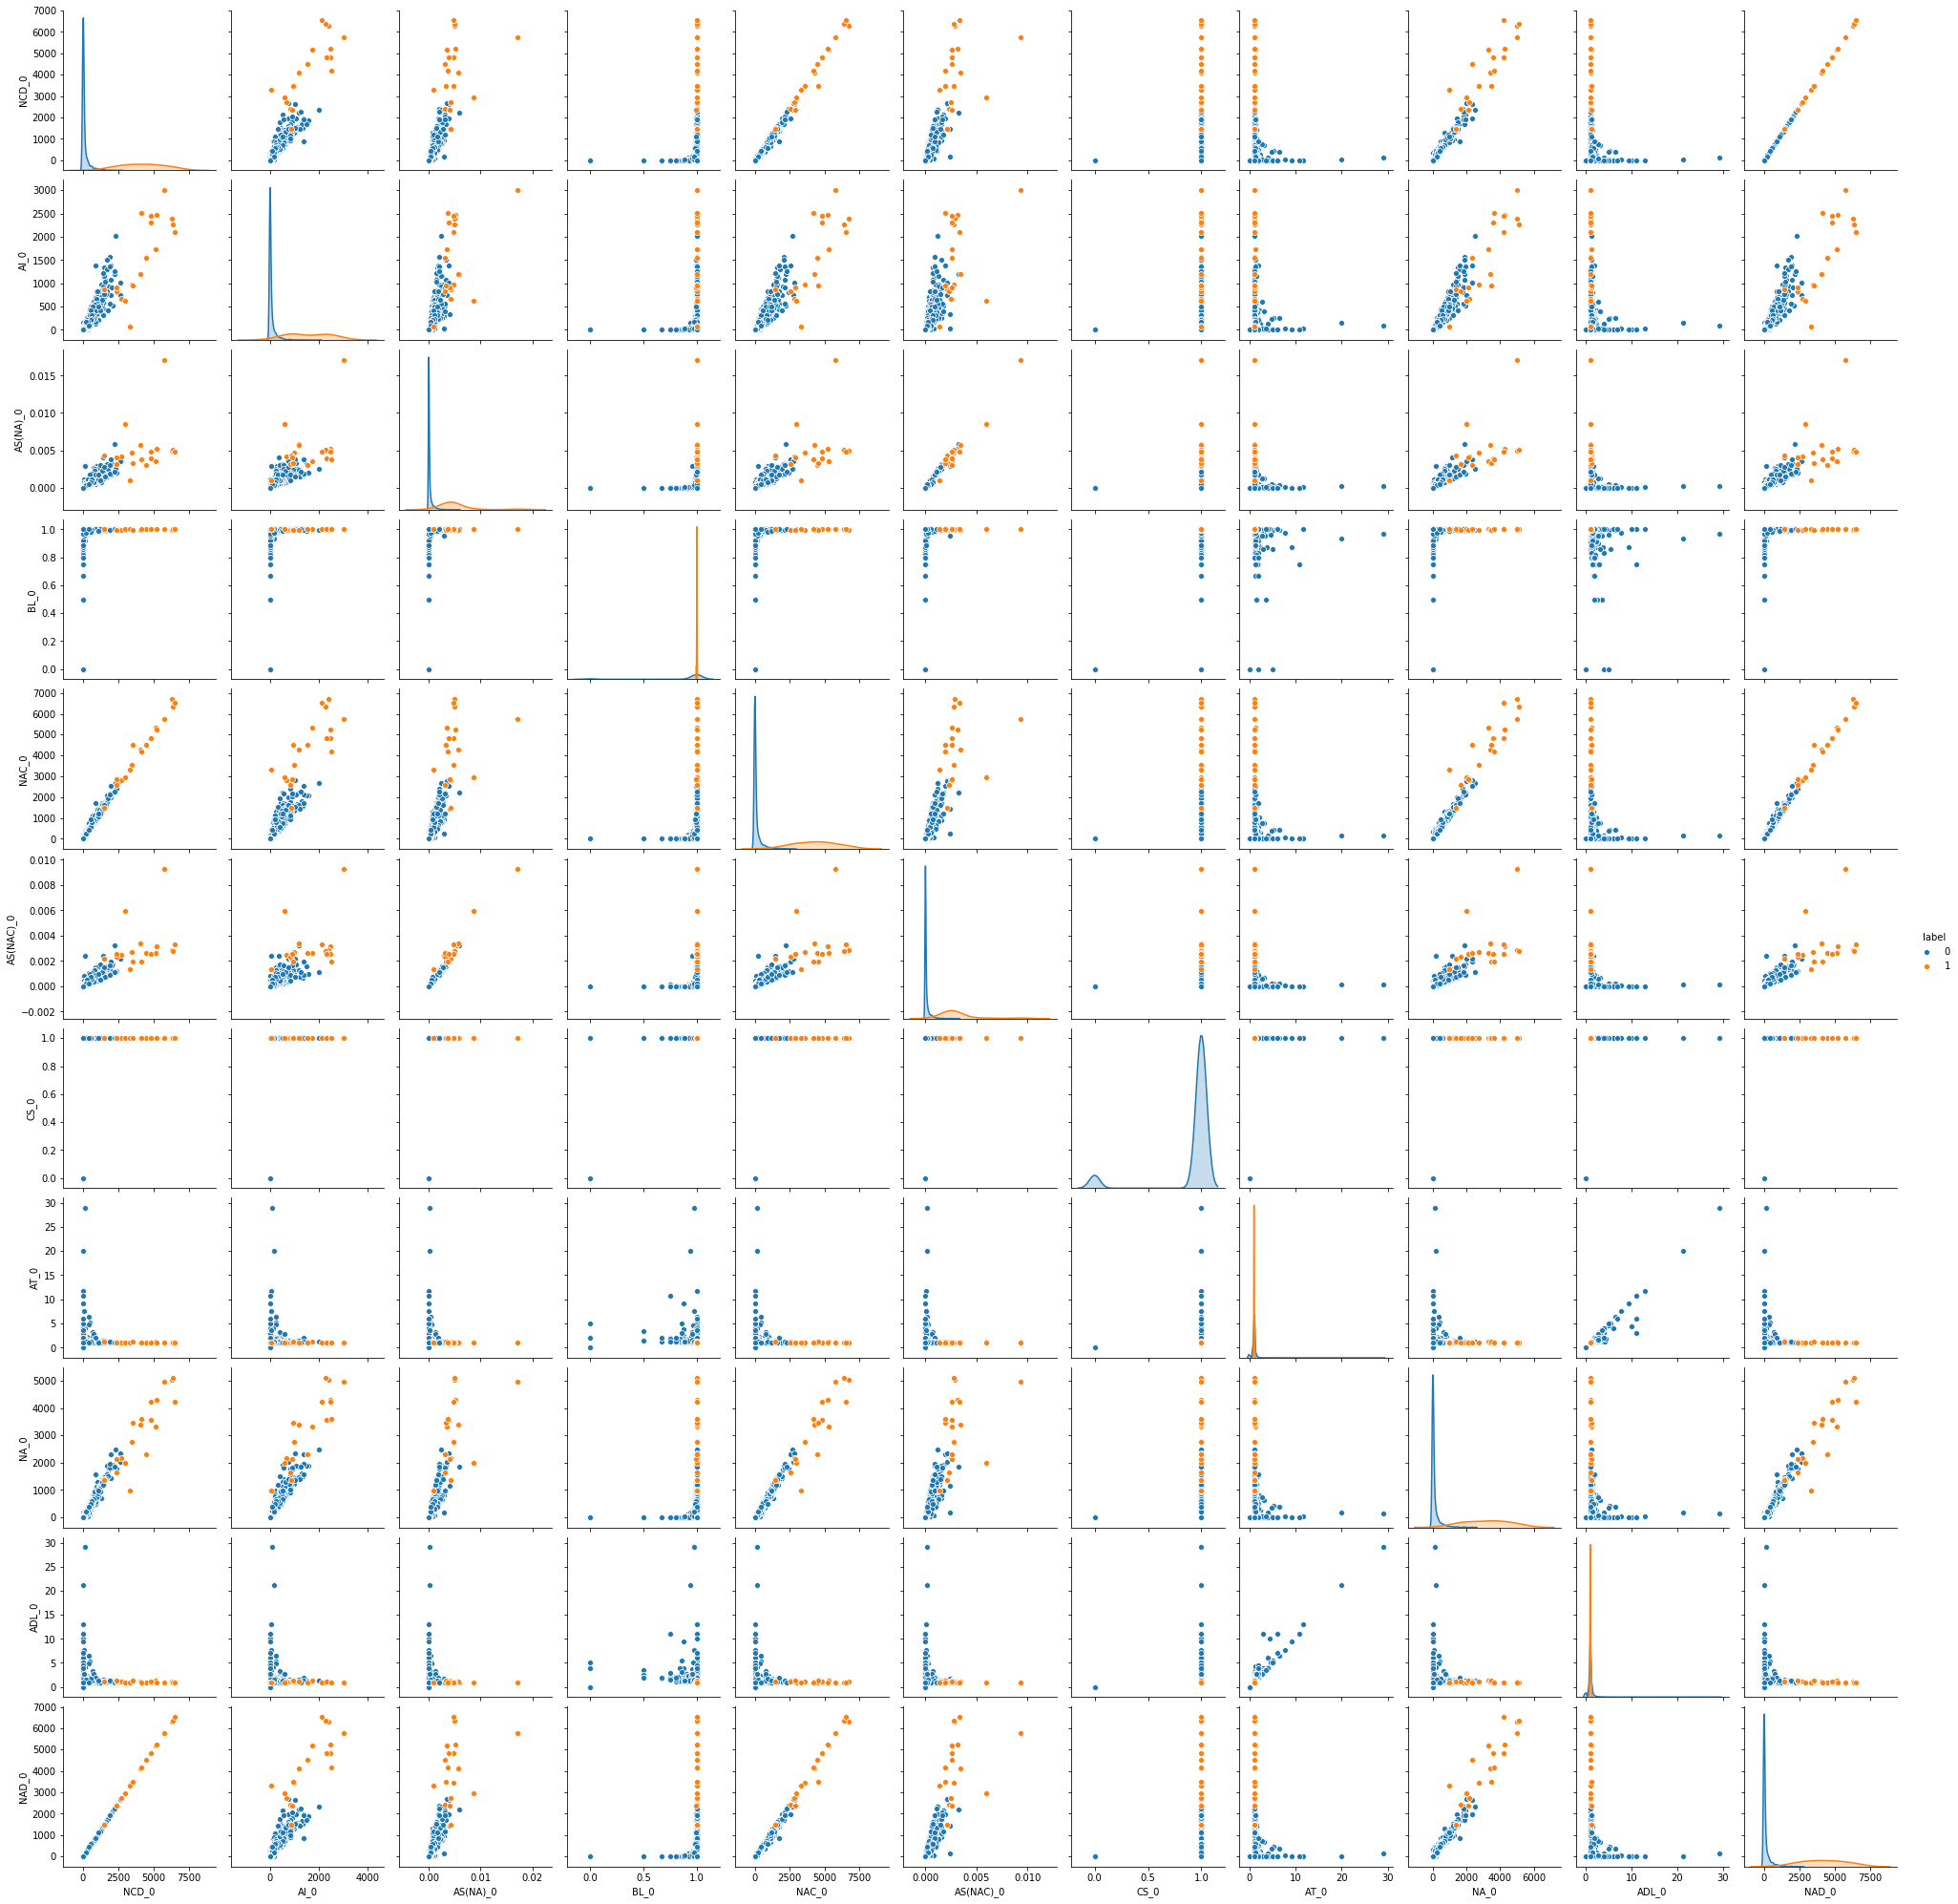

In [40]:
sns.pairplot(list_df_periods[0], hue='label', height=2.5);

Finalement, après notre étude, on comprend que le buzz demande de la quantité d'auteurs, de tweet, de discussion, etc...

# ROUND 1 : Nearest Neighbors Colored Classification

# ROUND 2 : try K-NN method

**optimise knn sur les données de twitter**

*   Ce script réalise les opérations suivantes:
*   Optimise l'hyperparamètre k par validation croisée (10-Fold) 
*   Récupère la valeur optimale de k
*   Réestime les modèles avec cette valeur optimale
*   Calcul le score du modèle optimal

In [32]:
def what_benefit_score(new, previous):
    benefit = 100 * (new - previous) / previous
    print("The result give ", round(benefit, 5), "% more accuracy than previously")
    if benefit > 0:
        print("It's better !!! ")
    else:
        print("No particular benefit :(")
    return benefit

Prepare a 10 fold cross validation partition

In [33]:
kf = KFold(n_splits=10, shuffle=True)

### Test with k = 5

In [34]:
def knn_fit(x_data, y_target, k=5):
    # test de knn
    clf = neighbors.KNeighborsRegressor(k)
    clf.fit(x_data, y_target)
    return clf.score(x_data, y_target)

# Test knn
score_train_ref = knn_fit(X_train, Y_train, k=5)
print(score_train_ref)
# For memory (test 1) : 0.92233

0.8567446485495412


Around 0.9 (most of the time) ... Awesome !!! Hazard Balthazar ?
### We hold that result as a reference result 

### Test knn with an bigger k = 10 (more neighbors)

In [39]:
score_train_more_neighbors = knn_fit(X_train, Y_train, k=10)
print(score_train_more_neighbors)
benefit_more_neighbors = what_benefit_score(
    score_train_more_neighbors, 
    score_train_ref
)
# For memory (test 1) : 0.86510

0.7995628045070047
('The result give ', -6.67432, '% more accuracy than previously')
No particular benefit :(


* High again... Awesome again ?!!!
* Well, the result is badder than the previous result, so 5 neighbors is better than 10.
### We can try just with few columns

In [40]:
# The scientific paper explains that ['NAC_', 'NCD_', 'NAD_'] are sufficient to predict the Y_MNAD
good_columns_label = []
for i in range(7):
    for label in ['NAC_', 'NCD_', 'NAD_']:
        good_columns_label.append(label + str(i))
X_train_light = X_train.copy()
X_test_light = X_test.copy()
# Redduce the features to 3 columns
X_train_light.drop(X_train.columns.difference(good_columns_label), axis=1, inplace=True)
X_test_light.drop(X_train.columns.difference(good_columns_label), axis=1, inplace=True)
print(X_train_light.head())

        NCD_0  NCD_1  NCD_2  NCD_3  NCD_4  NCD_5  NCD_6  NAC_0  NAC_1  NAC_2  \
431232      1      2      1      8      4      5      1      1      2      1   
159431    394   2202   1927   1988   2128   2090   2137    394   2202   1927   
395782     17     16     30     27     12     32     25     17     16     30   
411220     22     49     65     64     51     58     53     22     49     65   
498033      3      5      9      2     10      2     18      3      5      9   

        ...  NAC_4  NAC_5  NAC_6  NAD_0  NAD_1  NAD_2  NAD_3  NAD_4  NAD_5  \
431232  ...      4      5      1      1      2      1      8      4      5   
159431  ...   2128   2090   2137    394   2202   1927   1988   2128   2090   
395782  ...     12     32     25     17     16     30     27     12     32   
411220  ...     51     58     53     22     49     65     64     51     58   
498033  ...     10      2     18      3      5      9      2     10      2   

        NAD_6  
431232      1  
159431   2137  
39

In [41]:
# Test knn with this light dataset
score_train_light = knn_fit(X_train_light, Y_train, k=5)
print(score_train_light)
benefit_light = what_benefit_score(
    score_train_light, 
    score_train_ref
)

# for memory (test 1) : 0.92553 (just 3 features) > 0.92233 (with all features)

0.8633125098456615
('The result give ', 0.76661, '% more accuracy than previously')
It's better !!! 


### The result is very good again. Even better than the previous result including all features. So these three columns seem to be enough. Moreover, the other features cause interference...

In [42]:
print(X_train.head(5))

        NCD_0  NCD_1  NCD_2  NCD_3  NCD_4  NCD_5  NCD_6  AI_0  AI_1  AI_2  \
431232      1      2      1      8      4      5      1     1     2     1   
159431    394   2202   1927   1988   2128   2090   2137   324  1897  1590   
395782     17     16     30     27     12     32     25    15    10    21   
411220     22     49     65     64     51     58     53    17    27    43   
498033      3      5      9      2     10      2     18     2     3     4   

        ...  ADL_4  ADL_5  ADL_6  NAD_0  NAD_1  NAD_2  NAD_3  NAD_4  NAD_5  \
431232  ...    1.0    1.0    1.0      1      2      1      8      4      5   
159431  ...    1.0    1.0    1.0    394   2202   1927   1988   2128   2090   
395782  ...    1.0    1.0    1.0     17     16     30     27     12     32   
411220  ...    1.0    1.0    1.0     22     49     65     64     51     58   
498033  ...    1.0    1.0    1.0      3      5      9      2     10      2   

        NAD_6  
431232      1  
159431   2137  
395782     25  
4112

In [43]:
# Test knn with random features to confirm the previous result - we name it a 'datashit'
bad_columns_label = []
for i in range(2,7):
    for label in ['NA_', 'AI_', 'CS_']:
        bad_columns_label.append(label + str(i))
X_train_shit = X_train.copy()
X_train_shit.drop(X_train.columns.difference(bad_columns_label), axis=1, inplace=True)
print(X_train_shit.head())

# Test knn with a 'datashit'
score_train_shit = knn_fit(X_train_shit, Y_train, k=5)
print('\n')
print(score_train_shit)
benefit_shit = what_benefit_score(
    score_train_shit, 
    score_train_ref
)

        AI_2  AI_3  AI_4  AI_5  AI_6  CS_2  CS_3  CS_4  CS_5  CS_6  NA_2  \
431232     1     8     4     5     1   1.0   1.0   1.0   1.0   1.0     1   
159431  1590  1682  1837  1713  1679   1.0   1.0   1.0   1.0   1.0  1736   
395782    21    18     8    20    17   1.0   1.0   1.0   1.0   1.0    26   
411220    43    24    30    40    28   1.0   1.0   1.0   1.0   1.0    57   
498033     4     0     3     0    15   1.0   1.0   1.0   1.0   1.0     8   

        NA_3  NA_4  NA_5  NA_6  
431232     8     4     5     1  
159431  1840  2003  1866  1831  
395782    23    12    32    25  
411220    42    41    54    35  
498033     2     9     2    18  


0.7478501939660536
('The result give ', -12.71026, '% more accuracy than previously')
No particular benefit :(


### Result is less interesting. So, it confirms that the three features are the most important.

# ROUND 3 : improve the dataset preparation

### kNN, Optimise k, using ou X_train_light 
#### (with only the 3 survivor features)

In [58]:
def cross_validation(X_data, Y_target, method, kfold):
    i = 0
    score = 0
    # Validation croisée sur k-fold
    for learn, test in kfold.split(X_data):
        i += 1
        #print("\ti :", i)
        X_app = X_data.iloc[learn]
        Y_app = Y_target.iloc[learn]
        # FITTING
        method.fit(X_app,Y_app)

        X_val = X_data.iloc[test]
        Y_val = Y_target.iloc[test]
        score += method.score(X_val,Y_val)
        #print("\t\tscore :", method.score(X_val,Y_val))
  
    return score

In [59]:
def optimize_knn(X_train, Y_train, kfold, k_max, view=False):
    scores = []
    # Recherche d'un k optimisé
    for k in range(1,k_max):
        cross_score = 0
        clf = neighbors.KNeighborsRegressor(k)
        cross_score = cross_validation(X_train, Y_train, clf, kfold)
        if view :
            print("k : ", k, "cross score = ", cross_score)
        scores.append(cross_score)
    return scores

### Evaluate  using optimal hyperparameter value

In [60]:
# We want the best number of neighbors k, between 1 to 20
cross_scores = optimize_knn(X_train_light, Y_train, kf, k_max=20, view=True)
kopt = cross_scores.index(max(cross_scores)) + 1
score_train_kopt = knn_fit(X_train_light, Y_train, k=kopt)

print("The optimal k in the list = ", kopt)
print("Max fit score thanks this optimal k = ", score_train_kopt)
benefit_kopt = what_benefit_score(
    score_train_kopt, 
    score_train_ref
)

('k : ', 1, 'cross score = ', 8.06829675296192)
('k : ', 2, 'cross score = ', 8.509817765178692)
('k : ', 3, 'cross score = ', 8.635800954303724)
('k : ', 4, 'cross score = ', 8.447272430442796)
('k : ', 5, 'cross score = ', 8.405095522028917)
('k : ', 6, 'cross score = ', 8.467560035464123)
('k : ', 7, 'cross score = ', 8.355465189336238)
('k : ', 8, 'cross score = ', 8.440113883366635)
('k : ', 9, 'cross score = ', 8.441770740791963)
('k : ', 10, 'cross score = ', 8.379687609973754)
('k : ', 11, 'cross score = ', 8.316269547778827)
('k : ', 12, 'cross score = ', 8.349952191502352)
('k : ', 13, 'cross score = ', 8.23477078114346)
('k : ', 14, 'cross score = ', 8.165590117076333)
('k : ', 15, 'cross score = ', 8.197104804253792)
('k : ', 16, 'cross score = ', 8.124345038544496)
('k : ', 17, 'cross score = ', 8.192374628816411)
('k : ', 18, 'cross score = ', 8.11548696645252)
('k : ', 19, 'cross score = ', 8.128290785304728)
('The optimal k in the list = ', 3)
('Max fit score thanks thi

# Loop a lot of times to find the best k statistically

In [61]:
K_MAX = 20
def search_best_k(n_splits, total_laps, k_max=K_MAX, view=False):
    # Prepare the looping
    # We want to get the best k ever ! 
    # and we need to register the redoudance (frequency appearance) of each k during the looping

    kopt = 0
    kopt_score = 0
    kopt_count = list()
    kopt_count = [0 for _ in range(k_max + 1)]
    kopt_volume = [0 for _ in range(k_max + 1)]
    
    for lap in range(total_laps):
        kf2 = KFold(n_splits=n_splits, shuffle=True)
        if view:
            print("Lap : ", lap)
        new_scores = optimize_knn(X_train_light, Y_train, kf2, k_max, view=False)
        new_kopt = new_scores.index(max(new_scores)) + 1
        new_kopt_score = knn_fit(X_train_light, Y_train, k=new_kopt)
        if view:
            print('>> k :', new_kopt, ' -> score :', new_kopt_score)
        # Increment the k counter
        kopt_count[new_kopt] += 1
        kopt_volume[new_kopt] += new_kopt_score
        # Hold the k if better
        if kopt_score < new_kopt_score :
            if view:
                print('>>>>', new_kopt, ' is best than', kopt)
            kopt_score = new_kopt_score
            kopt = new_kopt  
    
    if view:
        print('Optimal k counter :', kopt_count)
        print('Optimal k volume :', kopt_volume)
    return (kopt, kopt_score, kopt_count, kopt_volume)

In [62]:
def show_result_optimization(kopt, kopt_score, kopt_count, kopt_volume):  
    print("\n Quality result :")
    print("The best score thanks best k = ", kopt)
    print("Max score with the best k = ", kopt_score)
    benefit_bestk = what_benefit_score(
        kopt_score, 
        score_train_ref
    )
    freq = max(kopt_count)
    freq_kopt = kopt_count.index(freq)
    freq_kopt_score = knn_fit(X_train_light, Y_train, k=freq_kopt)
    print("\n Frequency result :")
    print("The best k also the most frequent  = ", freq_kopt)
    print("Max score with the best k = ", freq_kopt_score)

    benefit_bestk = what_benefit_score(
        freq_kopt_score, 
        score_train_ref
    )
    
    volume = max(kopt_volume)
    volume_kopt = kopt_volume.index(volume)
    volume_kopt_score = knn_fit(X_train_light, Y_train, k=volume_kopt)
    print("\n Volume result :")
    print("The best k with the biggest volume  = ", volume_kopt)
    print("Max score with the best k = ", volume_kopt_score)

    benefit_bestk = what_benefit_score(
        volume_kopt_score, 
        score_train_ref
    )

In [63]:
result = search_best_k(n_splits=10, total_laps=20, view=True)
kopt, kopt_score, kopt_count, kopt_volume = result
show_result_optimization(kopt, kopt_score, kopt_count, kopt_volume) 

('Lap : ', 0)
('>> k :', 4, ' -> score :', 0.8889183085149776)
('>>>>', 4, ' is best than', 0)
('Lap : ', 1)
('>> k :', 5, ' -> score :', 0.8633125098456615)
('Lap : ', 2)
('>> k :', 2, ' -> score :', 0.9553480010331268)
('>>>>', 2, ' is best than', 4)
('Lap : ', 3)
('>> k :', 2, ' -> score :', 0.9553480010331268)
('Lap : ', 4)
('>> k :', 4, ' -> score :', 0.8889183085149776)
('Lap : ', 5)
('>> k :', 7, ' -> score :', 0.8304870239049658)
('Lap : ', 6)
('>> k :', 2, ' -> score :', 0.9553480010331268)
('Lap : ', 7)
('>> k :', 2, ' -> score :', 0.9553480010331268)
('Lap : ', 8)
('>> k :', 2, ' -> score :', 0.9553480010331268)
('Lap : ', 9)
('>> k :', 3, ' -> score :', 0.9220030792964975)
('Lap : ', 10)
('>> k :', 2, ' -> score :', 0.9553480010331268)
('Lap : ', 11)
('>> k :', 4, ' -> score :', 0.8889183085149776)
('Lap : ', 12)
('>> k :', 2, ' -> score :', 0.9553480010331268)
('Lap : ', 13)
('>> k :', 6, ' -> score :', 0.8457245845002028)
('Lap : ', 14)
('>> k :', 3, ' -> score :', 0.9220

### Now we want to find the best k for different kfold splitting
### for n_split from 5 to 35
### Warning : it's pretty long, so make you a coffee or check directly the result below... 

In [137]:
# Search the best k for several kfold spliting
kbest = 0
kbest_score = 0
kbest_count = list()
kbest_count = [0 for _ in range(K_MAX + 1)]
kbest_volume = [0 for _ in range(K_MAX + 1)]
view = True

for n_splits in range(5,35):
    print("N_splits = ", n_splits, " - wait, it's running...")
    result = search_best_k(n_splits=n_splits, total_laps=20, view=False)
    new_kbest, new_kbest_score, new_kbest_count, new_kbest_volume = result
    # Increment the k counter
    for k, count in enumerate(new_kbest_count):
        kbest_count[k] += count
    # Increment the k volume counter
    for k, volume in enumerate(new_kbest_volume):
        kbest_volume[k] += volume
    # Hold the k if better
    if kbest_score < new_kbest_score :
        if view:
            print('>>>>', new_kbest, ' is best than', kbest)
        kbest_score = new_kbest_score
        kbest = new_kbest 
    # Get the max of k frequencies
    freq = max(kbest_count)
    # Get k with the high frequency
    freq_kbest = kbest_count.index(freq)
    # Get the score of the k with the high frequency
    freq_kbest_score = knn_fit(X_train_light, Y_train, k=freq_kbest)
    if view:
        print('Best k counter :', kbest_count)
        print('Best k volume :', kbest_volume)

print('End')

('N_splits = ', 5)
('>>>>', 1, ' is best than', 0)
('Best k counter :', [0, 2, 7, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('N_splits = ', 6)
('Best k counter :', [0, 4, 14, 18, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('N_splits = ', 7)
('Best k counter :', [0, 4, 19, 30, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('N_splits = ', 8)
('Best k counter :', [0, 4, 27, 38, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('N_splits = ', 9)
('Best k counter :', [0, 4, 41, 43, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('N_splits = ', 10)
('Best k counter :', [0, 4, 44, 56, 15, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('N_splits = ', 11)
('Best k counter :', [0, 4, 50, 66, 17, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('N_splits = ', 12)
('Best k counter :', [0, 4, 55, 77, 20, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
('N_splits = ', 13)
('Best k counter :', [0, 4, 55, 93, 23, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [65]:
show_result_optimization(kbest, kbest_score, kbest_count) 

NameError: name 'kbest' is not defined

#### En conclusion, nous choisirons un k = 3, qui a le score le plus haut et le plus fréquent 

## TEST

In [66]:
clf = neighbors.KNeighborsRegressor(3)
clf.fit(X_train_light, Y_train)
print(clf.score(X_train_light, Y_train))
print(clf.score(X_test_light, Y_test))

0.9220030792964975
0.889075352709227


In [67]:
test_record = [0]
for k in range(1,K_MAX + 1):
    clf = neighbors.KNeighborsRegressor(k)
    clf.fit(X_train_light, Y_train)
    train_score = clf.score(X_train_light, Y_train)
    test_score = clf.score(X_test_light, Y_test)
    distance = round(100 * (test_score - train_score) / test_score , 4)
    precision = round(test_score * 100, 4)
    test_record.append(precision)
    print(k ,' - prec of test : ', precision, '%, dist to train : ', distance, '%')
#print('Best result', test_record.index(distance_minimum), ' : ', distance_minimum)
precision_min = max(test_record)
test_best_k = test_record.index(precision_min)
print(test_best_k)

(1, ' - prec of test : ', 92.6414, '%, dist to train : ', -7.9431, '%')
(2, ' - prec of test : ', 92.0646, '%, dist to train : ', -3.7693, '%')
(3, ' - prec of test : ', 88.9075, '%, dist to train : ', -3.7036, '%')
(4, ' - prec of test : ', 85.0768, '%, dist to train : ', -4.4842, '%')
(5, ' - prec of test : ', 80.3653, '%, dist to train : ', -7.4235, '%')
(6, ' - prec of test : ', 80.6449, '%, dist to train : ', -4.8701, '%')
(7, ' - prec of test : ', 78.7768, '%, dist to train : ', -5.4228, '%')
(8, ' - prec of test : ', 77.1884, '%, dist to train : ', -5.3713, '%')
(9, ' - prec of test : ', 75.3467, '%, dist to train : ', -6.1277, '%')
(10, ' - prec of test : ', 73.959, '%, dist to train : ', -8.7597, '%')
(11, ' - prec of test : ', 72.4388, '%, dist to train : ', -9.2584, '%')
(12, ' - prec of test : ', 70.7151, '%, dist to train : ', -10.4226, '%')
(13, ' - prec of test : ', 69.3033, '%, dist to train : ', -11.2612, '%')
(14, ' - prec of test : ', 68.2376, '%, dist to train : ', 

### We have a very good result with k = 3 (around 92%), and it should be stable enough.

# ROUND 4 : CART method

In [50]:
kf = KFold(n_splits=10, shuffle=True)

In [51]:
# Transform our dataframe to Numpyarray
X_train_light_np = X_train_light.to_numpy()
Y_train_np = Y_train.to_numpy()
X_test_light_np = X_test_light.to_numpy()
Y_test_np = Y_test.to_numpy()
print(type(X_train_light_np))
print(type(Y_train_np))

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


Optimize tree classifyer parameters, "criterion" and "max_leaf_nodes"

In [52]:
splitters = ["best", "random"]
LEAVES_REF = 5
#criteres = ["squared_error", "friedman_mse", "absolute_error", "poisson"]
# Since the last time, just only friedman_mse is working... 
clf = tree.DecisionTreeRegressor(criterion="friedman_mse", 
                                 splitter=splitters[0], 
                                 max_leaf_nodes=LEAVES_REF
                                 )

clf.fit(X_train_light, Y_train)
cart_score_ref = clf.score(X_test_light, Y_test)
print(cart_score_ref)

0.8706747866330505


#### Often less than 0.7 -> The result is not so satisfying

### We want to optimize it
#### choose best splitter in ["best", "random"]

In [53]:
#### To test beahviour, we fixe criterion to the first value "squared error"
scores=[]
for i in range(1,10):
    print("leaf : ", 5*i)
    for splitter in splitters :

        score=0
        clf = tree.DecisionTreeRegressor(criterion = "friedman_mse", 
                                         splitter = splitter, 
                                         max_leaf_nodes = LEAVES_REF*i
                                        )
        score = cross_validation(X_train, Y_train, clf, kf)
        scores.append(score)
        print("\t", splitter, " : ", score)


indice=scores.index(max(scores))

if indice % 2 == 0 :
    splitter_opt = "best"
    nb_leaf_opt = int(5*(int(indice/2)+1))
else :
    splitter_opt = "random"
    nb_leaf_opt = int(5*(int(indice-1)/2+1))

print("Splitter optimal :", splitter_opt)
print("Best leaves number :", nb_leaf_opt)

('leaf : ', 5)
('\t', 'best', ' : ', 5.531069191619816)
('\t', 'random', ' : ', 5.708978998464547)
('leaf : ', 10)
('\t', 'best', ' : ', 8.041651097271643)
('\t', 'random', ' : ', 6.334692874537985)
('leaf : ', 15)
('\t', 'best', ' : ', 8.33599760245738)
('\t', 'random', ' : ', 8.270077106361935)
('leaf : ', 20)
('\t', 'best', ' : ', 7.991510853897258)
('\t', 'random', ' : ', 5.963684381371154)
('leaf : ', 25)
('\t', 'best', ' : ', 7.471702100689306)
('\t', 'random', ' : ', 4.586197834756165)
('leaf : ', 30)
('\t', 'best', ' : ', 2.416182716148575)
('\t', 'random', ' : ', 8.124778070414731)
('leaf : ', 35)
('\t', 'best', ' : ', 8.18337630863171)
('\t', 'random', ' : ', 7.105111735075909)
('leaf : ', 40)
('\t', 'best', ' : ', 8.315899698705886)
('\t', 'random', ' : ', 8.42935704227922)
('leaf : ', 45)
('\t', 'best', ' : ', 7.9662415253800285)
('\t', 'random', ' : ', 8.360565060457649)
('Splitter optimal :', 'random')
('Best leaves number :', 40)


### Iterate among criterions 
### choose best splitter in ["best", "random"]

#### We choose the 'best' splitter in place of the random splitter

In [300]:
# We choose the 'best' splitter in place of the random splitter
#criteres = ["squared_error", "friedman_mse", "absolute_error"]
scores = []
step = 5
for i in range(1,0):
    
    score=0
    clf = tree.DecisionTreeRegressor(criterion = "friedman_mse", 
                                     max_leaf_nodes = step*i)
    score = cross_validation(X_train_light, Y_train, clf, kf)
    scores.append(score)
    print("leaf : ", step*i, ' : ', score)


indice = scores.index(max(scores))
dividor = len(criteres)
i = 0
'''
for crit in criteres:
    if indice % dividor == i :
        critere_opt = crit
        nb_leaf_opt = int(step * (int((indice - i) / dividor) + 1))
    i+=1
'''
print("score max :", max(scores))
print("feuilles opt :", nb_leaf_opt)

('leaf : ', 5, ' : ', 7.657883581523405)
('leaf : ', 10, ' : ', 8.592673620384826)
('leaf : ', 15, ' : ', 9.024415426233459)
('leaf : ', 20, ' : ', 8.766734880949938)
('leaf : ', 25, ' : ', 8.974458280098652)
('leaf : ', 30, ' : ', 8.85023897319671)
('leaf : ', 35, ' : ', 8.538007959417808)
('leaf : ', 40, ' : ', 8.652337845525386)
('leaf : ', 45, ' : ', 8.55358534063653)
('score max :', 9.024415426233459)
('feuilles opt :', 20)


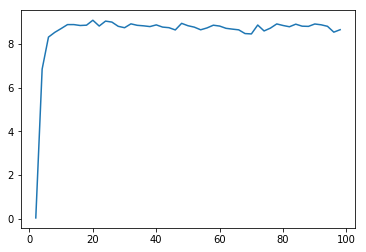

In [301]:
# visualize it in a graph
fig, ax = plt.subplots()  
# Plot our data on the axes.
ax.plot(leaves_list, scores_list);  

### A number of leaves between 5 and 30 looks to be fine

In [55]:
# We choose 'best' for splitter and 'friedman_mse' for criterion
# define our function to use easily
def algo_tree_best_mse(min_leaves=5, 
                       max_leaves=30,
                       view=False):
    scores = []
    leaves = []
    # Register the stability between to successives numbers of leaves
    scores_var = []

    score_previous = 0
    for i in range(min_leaves, max_leaves):
        score=0
        clf = tree.DecisionTreeRegressor(criterion = "friedman_mse", 
                                         max_leaf_nodes = i)
        score = cross_validation(X_train_light, Y_train, clf, kf)
        scores.append(score)
        scores_var.append(score - score_previous)
        leaves.append(i)
        if view:
            print("leaf : ", i, " : ", score) 
        score_previous = score
    return scores, scores_var, leaves

### Iterate 10 times to find the best number of leaves between 10 and 30
### Warning : it's pretty long, so make you a coffee or check directly the result below... 

('Lap : ', 0)
('score max :', 8.885796726799615)
('feuilles opt :', 18)
('Lap : ', 1)
('score max :', 8.796611769270394)
('feuilles opt :', 13)
('Lap : ', 2)
('score max :', 8.791704849283816)
('feuilles opt :', 28)
('Lap : ', 3)
('score max :', 8.796631388170747)
('feuilles opt :', 13)
('Lap : ', 4)
('score max :', 8.919018427292956)
('feuilles opt :', 13)
('Lap : ', 5)
('score max :', 8.73510463582877)
('feuilles opt :', 15)
('Lap : ', 6)
('score max :', 8.869185456514833)
('feuilles opt :', 26)
('Lap : ', 7)
('score max :', 8.715271430030274)
('feuilles opt :', 22)
('Lap : ', 8)
('score max :', 8.668542924948145)
('feuilles opt :', 28)
('Lap : ', 9)
('score max :', 8.80598129546729)
('feuilles opt :', 13)


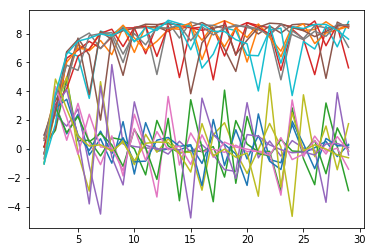

In [68]:
# Create a figure containing a single axes.
fig, ax = plt.subplots()  
view=True
# Register the optimal numbers of leaves
leaves_opt = []

for lap in range(10):
    print('Lap : ', lap)
    scores_list, scores_var_list, leaves_list = algo_tree_best_mse(
        min_leaves=2, 
        max_leaves=30, 
        view=False)
    # visualize it in a graph
    # Plot our data on the axes.
    score_max = max(scores_list)
    indice = scores_list.index(score_max)
    nb_leaf_opt = leaves_list[indice]
    leaves_opt.append(nb_leaf_opt)

    if view:
        print("score max :", score_max)
        print("feuilles opt :", nb_leaf_opt)

    ax.plot(leaves_list, scores_var_list);  
    ax.plot(leaves_list, scores_list);  

#### The number of leaves starts to give a good and stable result from 15 leaves

# TEST the CART model
* With Splitter = Best, 
* Criterion = Friedman_mse 
* and max_leaf_nodes = [20-40] 

In [69]:
# test our model with optimized hyper parameters
SPLITTER_OPT = "best"
CRITERION_OPT = "friedman_mse"
LEAVES_OPT = 15
clf = tree.DecisionTreeRegressor(criterion = CRITERION_OPT, 
                                 splitter = SPLITTER_OPT, 
                                 max_leaf_nodes = LEAVES_OPT
                                 )
clf.fit(X_train_light, Y_train)
cart_score_test = clf.score(X_test_light, Y_test)

print('Reference score (without optimization ~ ', LEAVES_REF, ' leaves : ', cart_score_ref)
print('Test score  ~ ', LEAVES_OPT, ' leaves: ', cart_score_test)

benefit_kopt = what_benefit_score(
    cart_score_test, 
    cart_score_ref
)

('Reference score (without optimization ~ ', 5, ' leaves : ', 0.8706747866330505)
('Test score  ~ ', 15, ' leaves: ', 0.9524480580445316)
('The result give ', 9.39194, '% more accuracy than previously')
It's better !!! 


### Generally we have a result reaching 90%, around a 10% increase

# ROUND 5 : decision tree classifyer ... FIGHT !

In [70]:
clf = tree.DecisionTreeClassifier(max_leaf_nodes=LEAVES_OPT, 
                                splitter = SPLITTER_OPT, 
                                criterion="entropy")
clf.fit(X_train_light, X_train_label['label'])
prev_test = clf.predict(X_test_light)
#print(prev_test)
score_tree = clf.score(X_test_light, X_test_label['label'])
# Compute the confusion matrix

cm=confusion_matrix(Y_test, prev_test)
# the confusion matrix is difficult to read as labels assigned by kmeans are arbitrary
print(cm)
print(scoretree)

NameError: name 'X_test_label' is not defined

In [406]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
print(dot_data.getvalue())
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.